In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten , Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
from tensorflow.keras.models import load_model

c:\Users\llh77\anaconda3\envs\Machine_Learning_part2\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Data Preprocessing

In [ ]:
main_path = "dataset\\"
file_path = []
class_names = []
image_size = (64,64,3)
num_class = 10
folder_class_name = os.listdir(main_path)

for folder in folder_class_name:
    sub_folder_path = os.path.join(main_path, folder)
    if pathlib.Path(sub_folder_path).suffix == "":
        fileList = os.listdir(sub_folder_path)

        for file in fileList:
            fpath = os.path.join(sub_folder_path, file)
            file_path.append(fpath)
            class_names.append(folder)

file_serie = pd.Series(file_path, name= 'filepath')
class_serie = pd.Series(class_names, name='class')
df = pd.concat([file_serie, class_serie], axis= 1)
df.head()

filepath        class
0              dataset\Altocumulus\download (1).jpg  Altocumulus
1        dataset\Altocumulus\download (1)_aug_0.jpg  Altocumulus
2  dataset\Altocumulus\download (1)_aug_0_aug_0.jpg  Altocumulus
3  dataset\Altocumulus\download (1)_aug_0_aug_1.jpg  Altocumulus
4        dataset\Altocumulus\download (1)_aug_1.jpg  Altocumulus

In [ ]:
df["class"].value_counts()

class
Cumulonimbus     1012
Cirrus            966
Nimbostratus      736
Altocumulus       598
Cirrocumulus      552
Cirrostratus      552
Stratocumulus     506
Stratus           506
Altostratus       460
Cumulus           414
Name: count, dtype: int64

In [ ]:
df["filepath"].str.split(".").str[-1].unique()

array(['jpg'], dtype=object)

In [ ]:
Cumulonimbus = df[df["class"] == "Cumulonimbus"].sample(n=500, replace=False)
Cirrus = df[df["class"] == "Cirrus"].sample(n=500, replace=False)
Nimbostratus = df[df["class"] == "Nimbostratus"].sample(n=500, replace=False)
Altocumulus = df[df["class"] == "Altocumulus"].sample(n=500, replace=False)
Cirrocumulus = df[df["class"] == "Cirrocumulus"].sample(n=500, replace=False)
Cirrostratus = df[df["class"] == "Cirrostratus"].sample(n=500, replace=False)
Stratocumulus = df[df["class"] == "Stratocumulus"].sample(n=500, replace=False)
Stratus = df[df["class"] == "Stratus"].sample(n=500, replace=False)
Altostratus = df[df["class"] == "Altostratus"]
Cumulus = df[df["class"] == "Cumulus"]
df_combined = pd.concat([Cumulonimbus, Cirrus, Nimbostratus,
                         Altocumulus, Cirrocumulus, Cirrostratus,
                         Stratocumulus, Stratus, Altostratus, Cumulus],
                         ignore_index=True)

df_combined

filepath         class
0     dataset\Cumulonimbus\images (1) (1)_aug_10_aug...  Cumulonimbus
1       dataset\Cumulonimbus\images (8)_aug_4_aug_0.jpg  Cumulonimbus
2     dataset\Cumulonimbus\download (2)_aug_5_aug_1.jpg  Cumulonimbus
3         dataset\Cumulonimbus\images (2) (1)_aug_1.jpg  Cumulonimbus
4     dataset\Cumulonimbus\images (1) (1)_aug_3_aug_...  Cumulonimbus
...                                                 ...           ...
4869             dataset\Cumulus\images_aug_8_aug_0.jpg       Cumulus
4870             dataset\Cumulus\images_aug_8_aug_1.jpg       Cumulus
4871                   dataset\Cumulus\images_aug_9.jpg       Cumulus
4872             dataset\Cumulus\images_aug_9_aug_0.jpg       Cumulus
4873             dataset\Cumulus\images_aug_9_aug_1.jpg       Cumulus

[4874 rows x 2 columns]

In [ ]:
df_shuffled = shuffle(df_combined).reset_index(drop=True)
df_shuffled

filepath         class
0     dataset\Cirrocumulus\download (3)_aug_14_aug_0...  Cirrocumulus
1      dataset\Cirrostratus\images (5)_aug_10_aug_0.jpg  Cirrostratus
2      dataset\Cumulonimbus\images (10)_aug_7_aug_0.jpg  Cumulonimbus
3      dataset\Cirrostratus\images (7)_aug_12_aug_0.jpg  Cirrostratus
4     dataset\Cirrostratus\download (2)_aug_9_aug_0.jpg  Cirrostratus
...                                                 ...           ...
4869  dataset\Nimbostratus\download (3) (1)_aug_0_au...  Nimbostratus
4870               dataset\Cirrus\images (4)_aug_13.jpg        Cirrus
4871  dataset\Nimbostratus\download (1)_aug_6_aug_1.jpg  Nimbostratus
4872         dataset\Stratus\images (1)_aug_9_aug_1.jpg       Stratus
4873                   dataset\Stratus\images_aug_6.jpg       Stratus

[4874 rows x 2 columns]

In [ ]:
encode = preprocessing.LabelEncoder()
df_shuffled["class"] = encode.fit_transform(df_shuffled["class"].values)


X = df_shuffled.iloc[:,0].values.flatten()
y = df_shuffled.iloc[:,-1].values.flatten()
X = pd.Series(X)
y = pd.Series(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
def img2data(path):
    rawImgs = []
    for imagePath in tqdm(path):
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img ,(64,64))
        rawImgs.append(img)

    return rawImgs

In [ ]:
new_X_train = img2data(X_train)
new_X_test = img2data(X_test)

100%|██████████| 1463/1463 [00:01<00:00, 938.35it/s] 


In [ ]:
new_X_train = np.array(new_X_train)
y_train = np.array(y_train)
new_X_test = np.array(new_X_test)
y_test = np.array(y_test)
new_X_train = new_X_train.astype('float32')
new_X_test = new_X_test.astype('float32')
new_X_train /= 255
new_X_test /= 255

new_X_train, X_val, new_y_train, y_val = train_test_split(new_X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
new_X_train.shape, X_val.shape, new_y_train.shape, y_val.shape , new_X_test.shape, y_test.shape

((2728, 64, 64, 3),
 (683, 64, 64, 3),
 (2728,),
 (683,),
 (1463, 64, 64, 3),
 (1463,))

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

batch_size = 32
epochs = 12
label = sorted(df["class"].unique().tolist())

# CNN

In [ ]:
CNNmodel = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = image_size),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(64, activation='relu'),
        Dense(num_class, activation='softmax'),

    ])

CNNmodel.summary()

c:\Users\llh77\anaconda3\envs\Machine_Learning_part2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 879,178 (3.35 MB)

 Trainable params: 879,178 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics= ['accuracy'])

In [ ]:
history = CNNmodel.fit(new_X_train, new_y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.1295 - loss: 2.2721 - val_accuracy: 0.2225 - val_loss: 2.0302
Epoch 2/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.2831 - loss: 1.8821 - val_accuracy: 0.3587 - val_loss: 1.7281
Epoch 3/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.4211 - loss: 1.6167 - val_accuracy: 0.4085 - val_loss: 1.6538
Epoch 4/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5315 - loss: 1.3862 - val_accuracy: 0.5388 - val_loss: 1.4486
Epoch 5/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.5773 - loss: 1.1976 - val_accuracy: 0.6794 - val_loss: 1.0132
Epoch 6/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6496 - loss: 0.9675 - val_accuracy: 0.7072 - val_loss: 0.9167
Epoch 7/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.7290 - loss: 0.7854 - val_accuracy: 0.7350 - val_loss: 0.8167
Epoch 8/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.7803 - loss: 0.6451 - val_accu

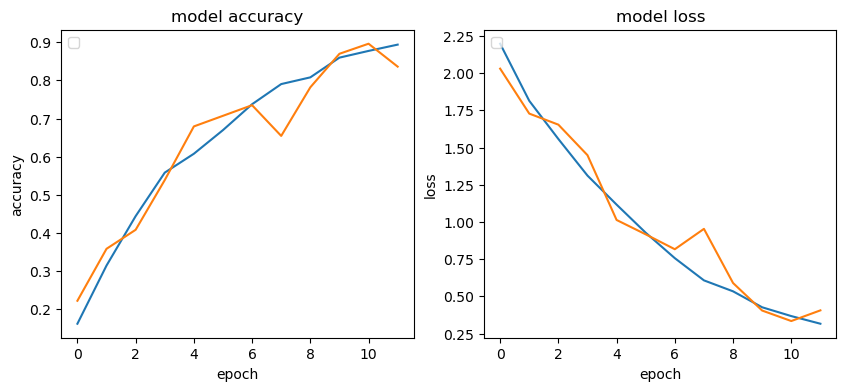

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['accuracy']);plt.plot(history.history['val_accuracy'])

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['loss']);plt.plot(history.history['val_loss'])


dataset\Nimbostratus\download (2)_aug_9_aug_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


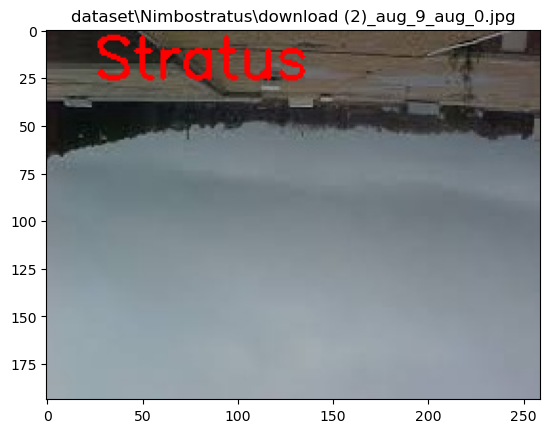

dataset\Altocumulus\images (1)_aug_11_aug_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


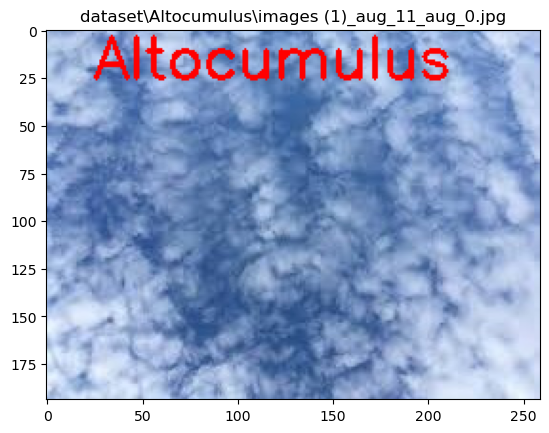

dataset\Cirrostratus\download (1)_aug_5_aug_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


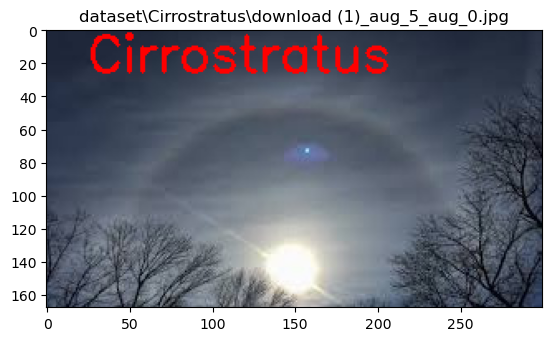

In [ ]:
rimg = []
for imagePath in (X_test.head(3)):
    print(imagePath)
    imgori = cv2.imread(imagePath)
    imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
    img = cv2.resize(imgori ,(64,64))
    rimg = np.array(img)
    rimg = rimg.astype('float32')
    rimg /= 255
    rimg = np.reshape(rimg ,(1,64,64,3))
    predict = CNNmodel.predict(rimg)
    result = label[np.argmax(predict)]
    plt.title(imagePath)
    cv2.putText(imgori, str(result), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )

    plt.imshow(imgori)
    plt.show()

In [ ]:
CNN_predict = CNNmodel.predict(new_X_test)
CNN_predict=np.argmax(CNN_predict,axis=1)
CNN_test_acc = accuracy_score(y_test, CNN_predict)

print(f"\nTrain Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Test Accuracy: {CNN_test_acc:.4f}\n")

CNN_CR = classification_report(y_test, CNN_predict, target_names=label, digits=4, output_dict=True)
print(classification_report(y_test, CNN_predict, target_names=label, digits=4))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Train Accuracy: 0.8937
Test Accuracy: 0.8852

               precision    recall  f1-score   support

  Altocumulus     0.9714    0.9067    0.9379       150
  Altostratus     0.9518    0.5725    0.7149       138
 Cirrocumulus     0.8994    0.9533    0.9256       150
 Cirrostratus     0.9091    1.0000    0.9524       150
       Cirrus     0.9385    0.8133    0.8714       150
 Cumulonimbus     0.9786    0.9133    0.9448       150
      Cumulus     0.9921    1.0000    0.9960       125
 Nimbostratus     0.8012    0.8867    0.8418       150
Stratocumulus     0.8836    0.8600    0.8716       150
      Stratus     0.6779    0.9400    0.7877       150

     accuracy                         0.8852      1463
    macro avg     0.9003    0.8846    0.8844      1463
 weighted avg     0.8984    0.8852    0.8839      1463



In [ ]:
CNNmodel.save('model\CNN_model.keras')

# MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=image_size, include_top=False, weights='imagenet')
base_model.trainable = False

MBNetmodel = Sequential([
    base_model,
    Conv2D(64, kernel_size=(3, 3), padding='same', activation = 'relu', input_shape = image_size),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.25),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(num_class, activation='softmax'),
    ])

MBNetmodel.summary()

C:\Users\llh77\AppData\Local\Temp\ipykernel_22364\3737562243.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=image_size, include_top=False, weights='imagenet')
c:\Users\llh77\anaconda3\envs\Machine_Learning_part2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073,994 (11.73 MB)

 Trainable params: 816,010 (3.11 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
MBNetmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics= ['accuracy'])

In [ ]:
history2 = MBNetmodel.fit(new_X_train, new_y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.1892 - loss: 2.2505 - val_accuracy: 0.4963 - val_loss: 1.8760
Epoch 2/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.4464 - loss: 1.7867 - val_accuracy: 0.7496 - val_loss: 1.1904
Epoch 3/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6609 - loss: 1.2239 - val_accuracy: 0.8697 - val_loss: 0.7227
Epoch 4/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7793 - loss: 0.8413 - val_accuracy: 0.9283 - val_loss: 0.4262
Epoch 5/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8753 - loss: 0.5457 - val_accuracy: 0.9531 - val_loss: 0.2709
Epoch 6/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9107 - loss: 0.3734 - val_accuracy: 0.9736 - val_loss: 0.1862
Epoch 7/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9427 - loss: 0.2789 - val_accuracy: 0.9780 - val_loss: 0.1217
Epoch 8/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9619 - loss: 0.1989 - val_accuracy: 0.9795 - 

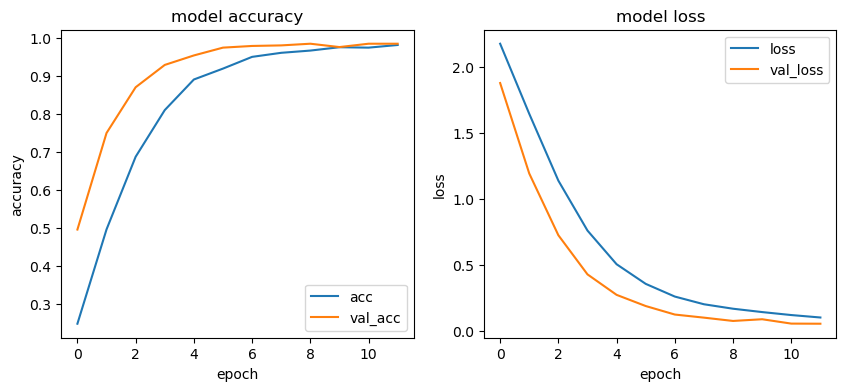

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history2.history['accuracy'], label='acc');plt.plot(history2.history['val_accuracy'], label='val_acc')
plt.legend()

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history2.history['loss'], label="loss");plt.plot(history2.history['val_loss'], label="val_loss")
plt.legend()


dataset\Nimbostratus\download (2)_aug_9_aug_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


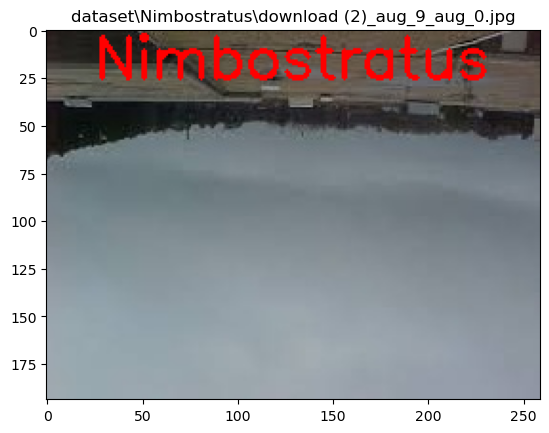

dataset\Altocumulus\images (1)_aug_11_aug_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


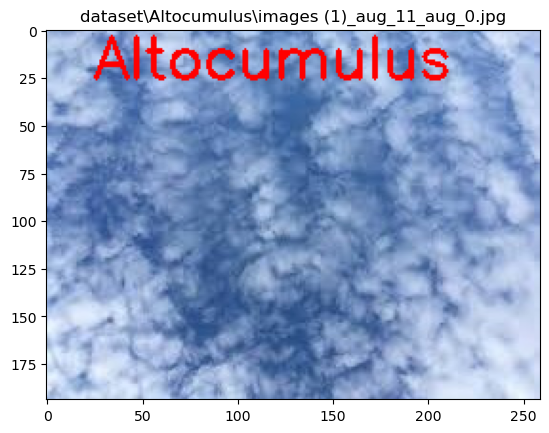

dataset\Cirrostratus\download (1)_aug_5_aug_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


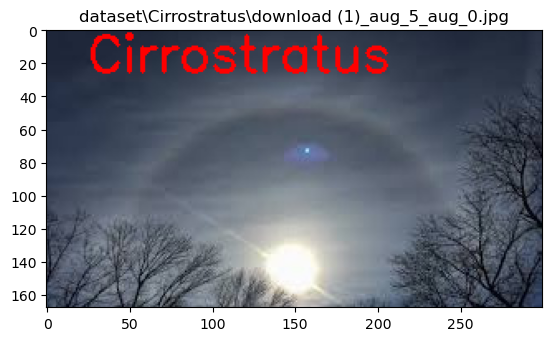

In [ ]:
rimg = []
for imagePath in (X_test.head(3)):
    print(imagePath)
    imgori = cv2.imread(imagePath)
    imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
    img = cv2.resize(imgori ,(64,64))
    rimg = np.array(img)
    rimg = rimg.astype('float32')
    rimg /= 255
    rimg = np.reshape(rimg ,(1,64,64,3))
    predict = MBNetmodel.predict(rimg)
    result = label[np.argmax(predict)]
    plt.title(imagePath)
    cv2.putText(imgori, str(result), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )

    plt.imshow(imgori)
    plt.show()

In [ ]:
MBNet_predict = MBNetmodel.predict(new_X_test)
MBNet_predict=np.argmax(MBNet_predict,axis=1)
MBNet_test_acc = accuracy_score(y_test, MBNet_predict)

print(f"\nTrain Accuracy: {history2.history['accuracy'][-1]:.4f}")
print(f"Test Accuracy: {MBNet_test_acc:.4f}\n")

MBNet_CR = classification_report(y_test, MBNet_predict, target_names=label, digits=4, output_dict=True)
print(classification_report(y_test, MBNet_predict, target_names=label, digits=4))

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

Train Accuracy: 0.9806
Test Accuracy: 0.9822

               precision    recall  f1-score   support

  Altocumulus     0.9317    1.0000    0.9646       150
  Altostratus     1.0000    1.0000    1.0000       138
 Cirrocumulus     1.0000    0.9267    0.9619       150
 Cirrostratus     1.0000    1.0000    1.0000       150
       Cirrus     1.0000    1.0000    1.0000       150
 Cumulonimbus     1.0000    1.0000    1.0000       150
      Cumulus     1.0000    1.0000    1.0000       125
 Nimbostratus     0.9530    0.9467    0.9498       150
Stratocumulus     0.9470    0.9533    0.9502       150
      Stratus     1.0000    1.0000    1.0000       150

     accuracy                         0.9822      1463
    macro avg     0.9832    0.9827    0.9827      1463
 weighted avg     0.9827    0.9822    0.9822      1463



In [ ]:
MBNetmodel.save('model\MBNet_model.keras')

# เตรียมข้อมูลสำหรับ model ของ scikit=learn

In [ ]:
sci_train_data = []
sci_train_label = []

for x, y in tqdm(zip(X_train, y_train)):
    # โหลดภาพด้วย OpenCV
    img = cv2.imread(x)

    # แปลงภาพเป็น RGB (เนื่องจาก OpenCV อ่านเป็น BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ปรับขนาดภาพเป็น 64x64
    img_resized = cv2.resize(img, (64, 64))

    # แปลงภาพเป็น 1D array (flatten)
    img_flattened = img_resized.flatten()

    # เพิ่มข้อมูลภาพและ label ลงใน list
    sci_train_data.append(img_flattened)
    sci_train_label.append(y)

# แปลง list เป็น numpy array
sci_train_data = np.asarray(sci_train_data)
sci_train_label = np.asarray(sci_train_label)
sci_train_data = sci_train_data.astype('float32') / 255.0

3411it [00:02, 1477.96it/s]


In [ ]:
sci_test_data = []
sci_test_label = []

for x, y in tqdm(zip(X_test, y_test)):
    # โหลดภาพด้วย OpenCV
    img = cv2.imread(x)

    # แปลงภาพเป็น RGB (เนื่องจาก OpenCV อ่านเป็น BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ปรับขนาดภาพเป็น 64x64
    img_resized = cv2.resize(img, (64, 64))

    # แปลงภาพเป็น 1D array (flatten)
    img_flattened = img_resized.flatten()

    # เพิ่มข้อมูลภาพและ label ลงใน list
    sci_test_data.append(img_flattened)
    sci_test_label.append(y)

sci_test_data = np.asarray(sci_test_data)
sci_test_label = np.asarray(sci_test_label)
sci_test_data = sci_test_data.astype('float32') / 255.0

1463it [00:00, 1500.77it/s]


# RF

In [ ]:
RF = RandomForestClassifier()
RF.fit(sci_train_data, sci_train_label)

RandomForestClassifier()

dataset\Nimbostratus\download (2)_aug_9_aug_0.jpg


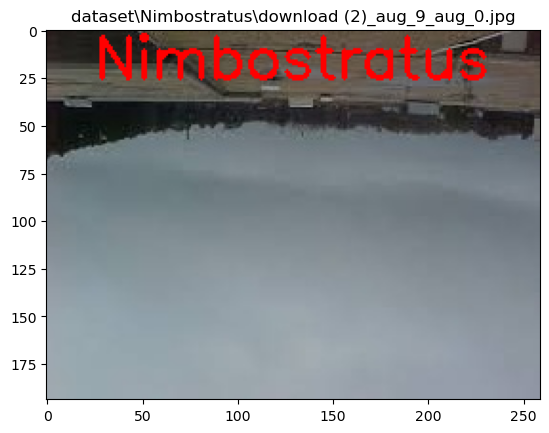

dataset\Altocumulus\images (1)_aug_11_aug_0.jpg


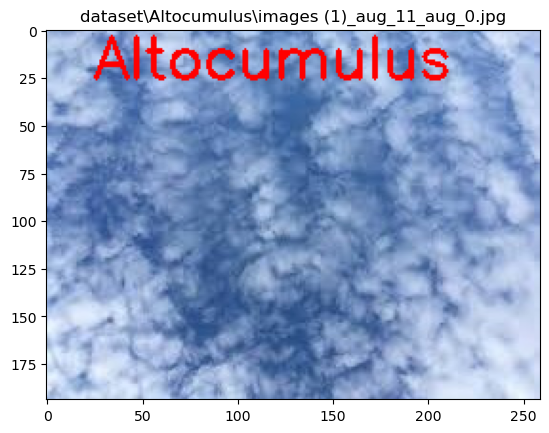

dataset\Cirrostratus\download (1)_aug_5_aug_0.jpg


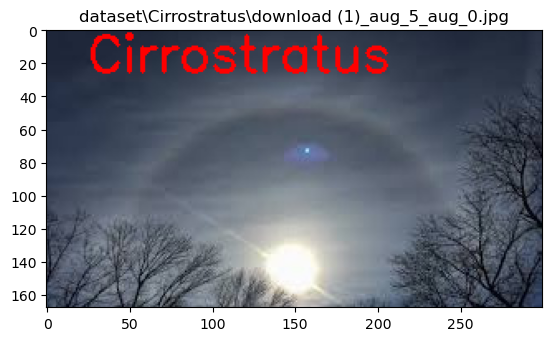

In [ ]:
rimg = []
for imagePath in (X_test.head(3)):
    print(imagePath)
    imgori = cv2.imread(imagePath)
    imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
    img = cv2.resize(imgori ,(64,64))
    rimg = img.flatten()
    rimg = rimg.astype('float32')
    rimg /= 255
    rimg = rimg.reshape(1, -1)
    predict = RF.predict(rimg)
    result = label[predict[0]]
    plt.title(imagePath)
    cv2.putText(imgori, str(result), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )

    plt.imshow(imgori)
    plt.show()

In [ ]:
RF_prediction = RF.predict(sci_test_data)
RF_train_acc = accuracy_score(sci_train_label, RF.predict(sci_train_data))
RF_test_acc = accuracy_score(sci_test_label, RF_prediction)

print(f"Train Accuracy: {RF_train_acc:.4f}")
print(f"Test Accuracy: {RF_test_acc:.4f}\n")

RF_CR = classification_report(sci_test_label, RF_prediction, target_names=label, digits=4, output_dict=True)
print(classification_report(sci_test_label, RF_prediction, target_names=label, digits=4))

Train Accuracy: 0.9950
Test Accuracy: 0.9925

               precision    recall  f1-score   support

  Altocumulus     1.0000    1.0000    1.0000       150
  Altostratus     1.0000    1.0000    1.0000       138
 Cirrocumulus     1.0000    1.0000    1.0000       150
 Cirrostratus     1.0000    1.0000    1.0000       150
       Cirrus     1.0000    1.0000    1.0000       150
 Cumulonimbus     1.0000    1.0000    1.0000       150
      Cumulus     1.0000    1.0000    1.0000       125
 Nimbostratus     0.9929    0.9333    0.9622       150
Stratocumulus     0.9371    0.9933    0.9644       150
      Stratus     1.0000    1.0000    1.0000       150

     accuracy                         0.9925      1463
    macro avg     0.9930    0.9927    0.9927      1463
 weighted avg     0.9928    0.9925    0.9925      1463



In [ ]:
joblib.dump(RF, 'model\RF_model.pkl')

['model\\RF_model.pkl']

# KNN

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(sci_train_data, sci_train_label)

KNeighborsClassifier()

dataset\Nimbostratus\download (2)_aug_9_aug_0.jpg


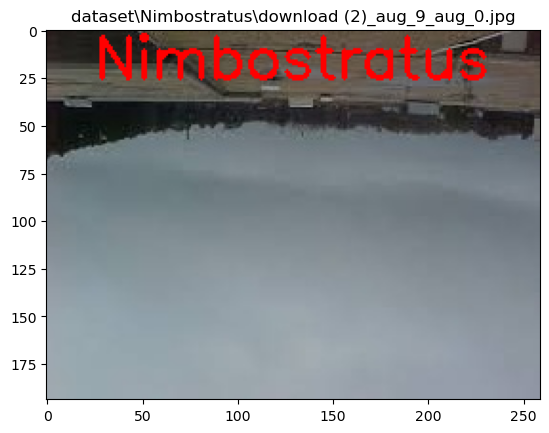

dataset\Altocumulus\images (1)_aug_11_aug_0.jpg


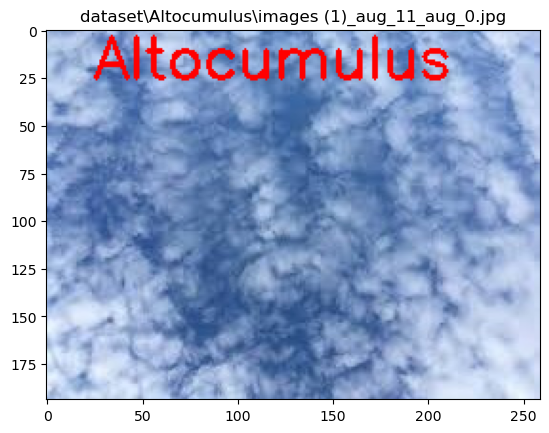

dataset\Cirrostratus\download (1)_aug_5_aug_0.jpg


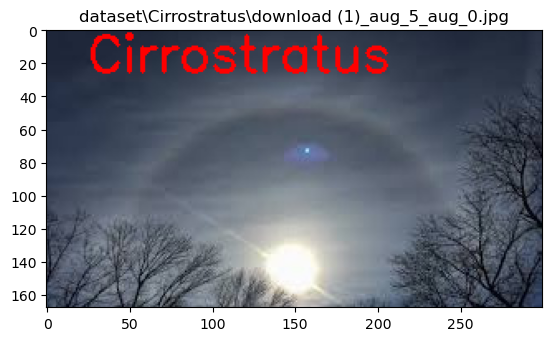

In [ ]:
rimg = []
for imagePath in (X_test.head(3)):
    print(imagePath)
    imgori = cv2.imread(imagePath)
    imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
    img = cv2.resize(imgori ,(64,64))
    rimg = img.flatten()
    rimg = rimg.astype('float32')
    rimg /= 255
    rimg = rimg.reshape(1, -1)
    predict = KNN.predict(rimg)
    result = label[predict[0]]
    plt.title(imagePath)
    cv2.putText(imgori, str(result), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )

    plt.imshow(imgori)
    plt.show()

In [ ]:
KNN_prediction = KNN.predict(sci_test_data)
KNN_train_acc = accuracy_score(sci_train_label, KNN.predict(sci_train_data))
KNN_test_acc = accuracy_score(sci_test_label, KNN_prediction)

print(f"Train Accuracy: {KNN_train_acc:.4f}")
print(f"Test Accuracy: {KNN_test_acc:.4f}\n")

KNN_CR = classification_report(sci_test_label, KNN_prediction, target_names=label, digits=4, output_dict=True)
print(classification_report(sci_test_label, KNN_prediction, target_names=label, digits=4))

Train Accuracy: 0.9845
Test Accuracy: 0.9617

               precision    recall  f1-score   support

  Altocumulus     1.0000    0.9667    0.9831       150
  Altostratus     0.9650    1.0000    0.9822       138
 Cirrocumulus     0.9859    0.9333    0.9589       150
 Cirrostratus     0.9236    0.9667    0.9446       150
       Cirrus     0.9650    0.9200    0.9420       150
 Cumulonimbus     1.0000    0.9333    0.9655       150
      Cumulus     1.0000    1.0000    1.0000       125
 Nimbostratus     0.9658    0.9400    0.9527       150
Stratocumulus     0.9119    0.9667    0.9385       150
      Stratus     0.9202    1.0000    0.9585       150

     accuracy                         0.9617      1463
    macro avg     0.9638    0.9627    0.9626      1463
 weighted avg     0.9631    0.9617    0.9618      1463



In [ ]:
joblib.dump(KNN, 'model\KNN_model.pkl')

['model\\KNN_model.pkl']

# ตาราง Accuracy

In [ ]:
accuracy_table = pd.DataFrame(index=["CNN","MobileNetV2","Random Forest","KNN"],columns=["Accuracy"])
accuracy_table["Accuracy"] = [CNN_test_acc*100,MBNet_test_acc*100,RF_test_acc*100,KNN_test_acc*100]
accuracy_table = accuracy_table.round(2).sort_values(by=["Accuracy"],ascending=False)

In [ ]:
accuracy_table

Accuracy
Random Forest     99.25
MobileNetV2       98.22
KNN               96.17
CNN               88.52

# ตาราง Precision และ Recall

In [ ]:
accuracy_df= pd.DataFrame(columns=["Model","Cloud","Precision","Recall"])
accuracy_df.loc[len(accuracy_df)] = ["CNN","Cumulonimbus",CNN_CR["Cumulonimbus"]["precision"]*100,CNN_CR["Cumulonimbus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["CNN","Nimbostratus",CNN_CR["Nimbostratus"]["precision"]*100,CNN_CR["Nimbostratus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["MobileNetV2","Cumulonimbus",MBNet_CR["Cumulonimbus"]["precision"]*100,MBNet_CR["Cumulonimbus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["MobileNetV2","Nimbostratus",MBNet_CR["Nimbostratus"]["precision"]*100,MBNet_CR["Nimbostratus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["Random Forest","Cumulonimbus",RF_CR["Cumulonimbus"]["precision"]*100,RF_CR["Cumulonimbus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["Random Forest","Nimbostratus",RF_CR["Nimbostratus"]["precision"]*100,RF_CR["Nimbostratus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["KNN","Cumulonimbus",KNN_CR["Cumulonimbus"]["precision"]*100,KNN_CR["Cumulonimbus"]["recall"]*100]
accuracy_df.loc[len(accuracy_df)] = ["KNN","Nimbostratus",KNN_CR["Nimbostratus"]["precision"]*100,KNN_CR["Nimbostratus"]["recall"]*100]

In [ ]:
Cumulonimbus_table = accuracy_df[accuracy_df["Cloud"] == "Cumulonimbus"].round(2).sort_values(by=["Model"],ascending=[True])
Nimbostratus_table = accuracy_df[accuracy_df["Cloud"] == "Nimbostratus"].round(2).sort_values(by=["Model"],ascending=[True])

In [ ]:
Cumulonimbus_table.reset_index(drop=True)

Model         Cloud  Precision  Recall
0            CNN  Cumulonimbus      97.86   91.33
1            KNN  Cumulonimbus     100.00   93.33
2    MobileNetV2  Cumulonimbus     100.00  100.00
3  Random Forest  Cumulonimbus     100.00  100.00

In [ ]:
Nimbostratus_table.reset_index(drop=True)

Model         Cloud  Precision  Recall
0            CNN  Nimbostratus      80.12   88.67
1            KNN  Nimbostratus      96.58   94.00
2    MobileNetV2  Nimbostratus      95.30   94.67
3  Random Forest  Nimbostratus      99.29   93.33

# กราฟ Accuracy, Precision และ Recall

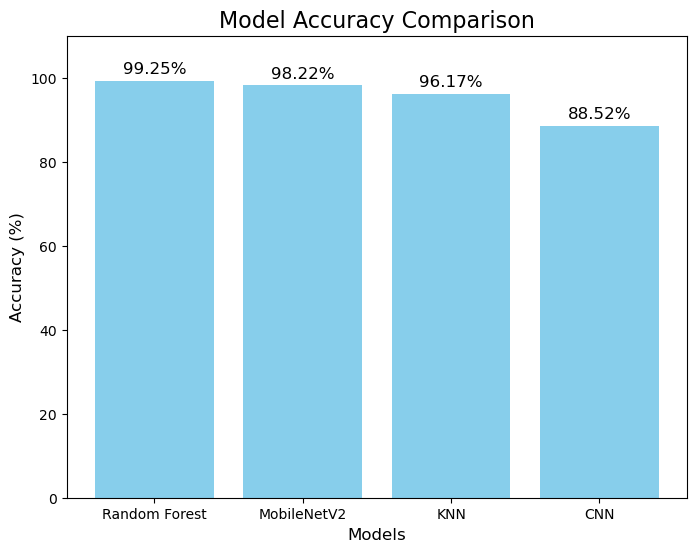

In [ ]:
sort_by_acc = accuracy_table.sort_values(by=["Accuracy"],ascending=False)

plt.figure(figsize=(8, 6))  # กำหนดขนาดของกราฟ
plt.bar(sort_by_acc.index, sort_by_acc["Accuracy"], color='skyblue')  # ใช้ bar plot

# ตั้งชื่อกราฟและ label
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# แสดงค่า accuracy บน bar
for i, v in enumerate(sort_by_acc["Accuracy"]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontsize=12)

plt.ylim(0, 110)
# แสดงกราฟ
plt.show()

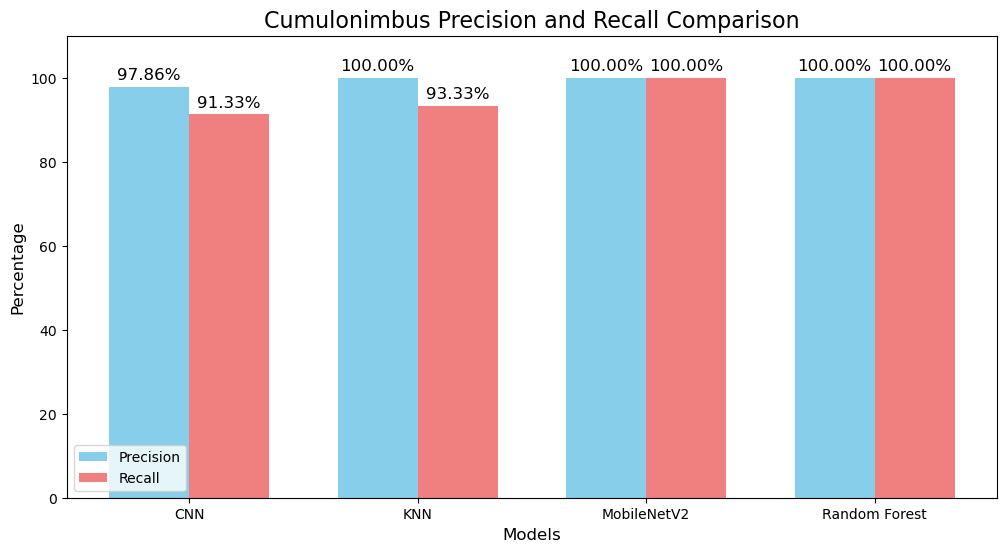

In [ ]:
Cumulonimbus_sort = Cumulonimbus_table.sort_values(by=["Model"], ascending=True)

# กำหนดขนาดของกราฟ
plt.figure(figsize=(12, 6))

# กำหนดตำแหน่งของบาร์ (bar positions) สำหรับทั้ง Precision และ Recall
bar_width = 0.35
index = np.arange(len(Cumulonimbus_sort))

# วาดบาร์สำหรับ Precision
plt.bar(index, Cumulonimbus_sort["Precision"], bar_width, label='Precision', color='skyblue')

# วาดบาร์สำหรับ Recall โดยย้ายตำแหน่งไปทางขวา
plt.bar(index + bar_width, Cumulonimbus_sort["Recall"], bar_width, label='Recall', color='lightcoral')

# ตั้งชื่อกราฟและ label
plt.title("Cumulonimbus Precision and Recall Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Percentage", fontsize=12)

# ปรับแสดงค่าในแต่ละบาร์
for i, (precision, recall) in enumerate(zip(Cumulonimbus_sort["Precision"], Cumulonimbus_sort["Recall"])):
    plt.text(i, precision + 1, f"{precision:.2f}%", ha='center', va='bottom', fontsize=12)
    plt.text(i + bar_width, recall + 1, f"{recall:.2f}%", ha='center', va='bottom', fontsize=12)

# ตั้งตำแหน่งของ x-axis ให้ตรงกับชื่อโมเดล
plt.xticks(index + bar_width / 2, Cumulonimbus_sort["Model"])
plt.ylim(0, 110)
# แสดง legend
plt.legend()

# แสดงกราฟ
plt.show()

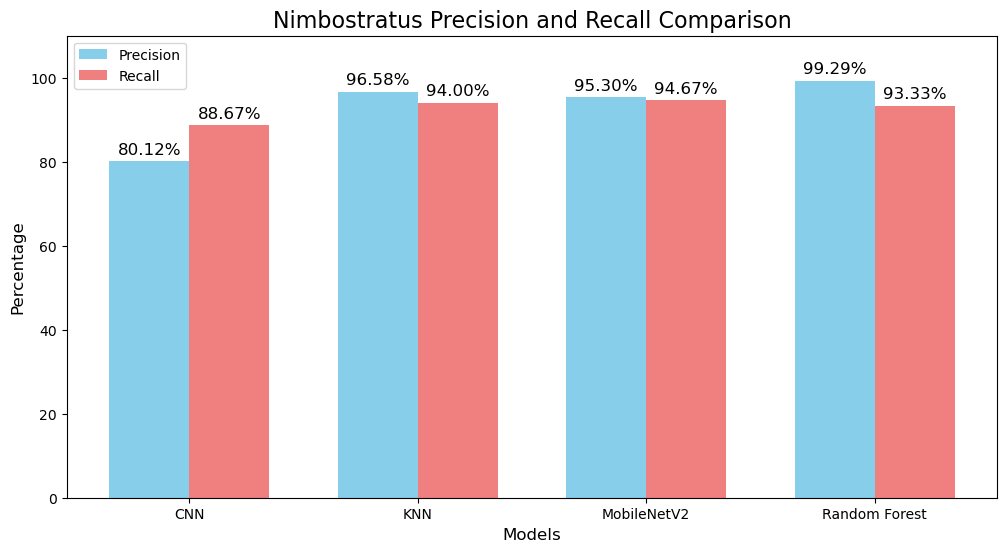

In [ ]:
Nimbostratus_sort = Nimbostratus_table.sort_values(by=["Model"], ascending=True)

# กำหนดขนาดของกราฟ
plt.figure(figsize=(12, 6))

# กำหนดตำแหน่งของบาร์ (bar positions) สำหรับทั้ง Precision และ Recall
bar_width = 0.35
index = np.arange(len(Nimbostratus_sort))

# วาดบาร์สำหรับ Precision
plt.bar(index, Nimbostratus_sort["Precision"], bar_width, label='Precision', color='skyblue')

# วาดบาร์สำหรับ Recall โดยย้ายตำแหน่งไปทางขวา
plt.bar(index + bar_width, Nimbostratus_sort["Recall"], bar_width, label='Recall', color='lightcoral')

# ตั้งชื่อกราฟและ label
plt.title("Nimbostratus Precision and Recall Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Percentage", fontsize=12)

# ปรับแสดงค่าในแต่ละบาร์
for i, (precision, recall) in enumerate(zip(Nimbostratus_sort["Precision"], Nimbostratus_sort["Recall"])):
    plt.text(i, precision + 1, f"{precision:.2f}%", ha='center', va='bottom', fontsize=12)
    plt.text(i + bar_width, recall + 1, f"{recall:.2f}%", ha='center', va='bottom', fontsize=12)

# ตั้งตำแหน่งของ x-axis ให้ตรงกับชื่อโมเดล
plt.xticks(index + bar_width / 2, Nimbostratus_sort["Model"])
plt.ylim(0, 110)
# แสดง legend
plt.legend()

# แสดงกราฟ
plt.show()

# ทดลอง

In [ ]:
load_CNN = load_model("model\CNN_model.keras")
load_MBNet = load_model("model\MBNet_model.keras")
load_RF = joblib.load('model\RF_model.pkl')
load_KNN = joblib.load("model\KNN_model.pkl")

Nimbostratus.jpg


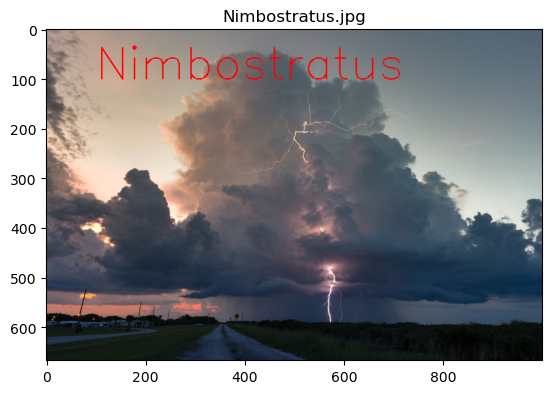

In [ ]:
rimg = []
imagePath = "Nimbostratus.jpg"
print(imagePath)
imgori = cv2.imread(imagePath)
imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
img = cv2.resize(imgori ,(64,64))
rimg = img.flatten()
rimg = rimg.astype('float32')
rimg /= 255
rimg = rimg.reshape(1, -1)
# rimg = np.reshape(rimg ,(1,64,64,3))
predict = load_RF.predict(rimg)
result = label[predict[0]]
# result = label[np.argmax(predict)]
plt.title(imagePath)
cv2.putText(imgori, str(result), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 2 )

plt.imshow(imgori)
plt.show()

Cumu.jpg


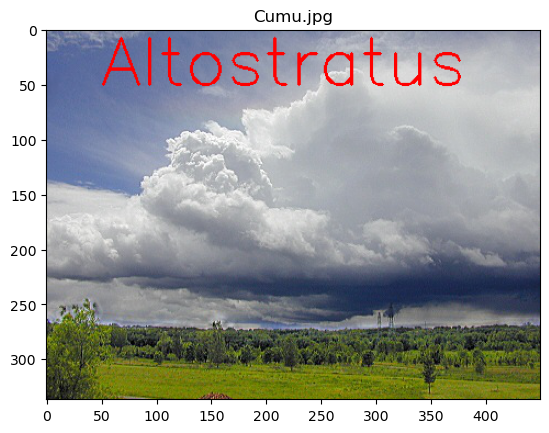

In [ ]:
rimg = []
imagePath = "Cumu.jpg"
print(imagePath)
imgori = cv2.imread(imagePath)
imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
img = cv2.resize(imgori ,(64,64))
rimg = img.flatten()
rimg = rimg.astype('float32')
rimg /= 255
# rimg = np.reshape(rimg ,(1,64,64,3))
rimg = rimg.reshape(1, -1)
predict = load_RF.predict(rimg)
result = label[predict[0]]
# result = label[np.argmax(predict)]
plt.title(imagePath)
cv2.putText(imgori, str(result), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2 )

plt.imshow(imgori)
plt.show()

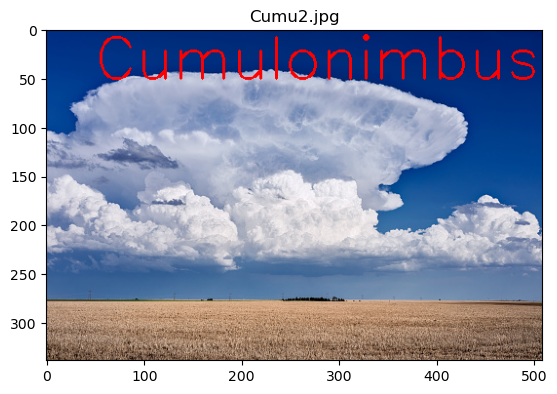

In [ ]:
rimg = []
imagePath = "Cumu2.jpg"
# print(imagePath)
imgori = cv2.imread(imagePath)
imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
img = cv2.resize(imgori ,(64,64))
rimg = np.array(img)
rimg = rimg.astype('float32')
rimg /= 255
rimg = rimg.reshape(1, -1)
# rimg = np.reshape(rimg ,(1,64,64,3))
predict = load_RF.predict(rimg)
result = label[predict[0]]
# result = label[np.argmax(predict)]
plt.title(imagePath)
cv2.putText(imgori, str(result), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2 )

plt.imshow(imgori)
plt.show()

mushroom_cloud.jpg


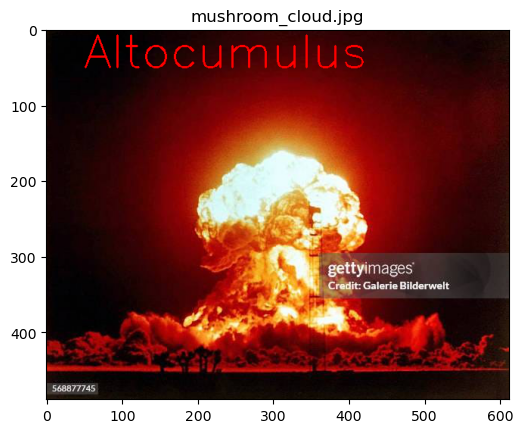

In [ ]:
rimg = []
imagePath = "mushroom_cloud.jpg"
print(imagePath)
imgori = cv2.imread(imagePath)
imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
img = cv2.resize(imgori ,(64,64))
rimg = img.flatten()
rimg = rimg.astype('float32')
rimg /= 255
rimg = rimg.reshape(1, -1)
# rimg = np.reshape(rimg ,(1,64,64,3))
predict = load_RF.predict(rimg)
# result = label[predict[0]]
result = label[np.argmax(predict)]
plt.title(imagePath)
cv2.putText(imgori, str(result), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2 )

plt.imshow(imgori)
plt.show()